# Library

In [340]:
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from joblib import parallel_backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Function

In [341]:
def check(x, y, numerical=True):
  # for numeric (and/or categorical) values
  if numerical:
    if x.dtype == 'O':
      correlation, p_value = stats.pointbiserialr(x.astype('category').cat.codes, y)
    else:
      correlation, p_value = stats.pointbiserialr(x, y)
    print(f"Point-biserial correlation between {x.name} and 'credit_risk':", correlation)
    print(f"Point-biserial P-value between {x.name} and 'credit_risk':", p_value)
    
  # for non-numeric categorical values
  else:
    cross_tab = pd.crosstab(x, y)

    chi2, _, _, _ = stats.chi2_contingency(cross_tab)
    num_rows = cross_tab.shape[0]
    num_cols = cross_tab.shape[1]
    min_dim = min(num_rows - 1, num_cols - 1)
    cramer_v = np.sqrt(chi2 / (len(x) * min_dim))
  
    print(f"Cramér's V between {x.name} and 'credit_risk':", cramer_v)

def outliers(data, threshold=1.5, remove=False):
  
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  lower_bound = q1 - threshold * iqr
  upper_bound = q3 + threshold * iqr
  outliers_mask = (data < lower_bound) | (data > upper_bound)
  num_outliers = np.sum(outliers_mask)
  if remove:
    return outliers_mask
  else:
    return num_outliers

def describe(data):
  # number of NaN values
  n_na = data.isna().sum()
  if data.dtype == 'O':
    print('summary:')
    print(f'NaN\t {n_na:<5} {n_na/len(data)*100:.2f}%\n{data.describe()}\n')
    print(f'number of unique values: {data.nunique()}, which are: {data.unique()}\n')

    print(data.head(5))
  
  else:

    print('summary:')
    print(f'outliers {outliers(data):<5} {outliers(data)/len(data)*100:.2f}%')
    print(f'NaN\t {n_na:<5} {n_na/len(data)*100:.2f}%\n{data.describe()}\n')
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(data)
    plt.title(f'Summary Statistics - {data.name}')
    plt.xlabel(data.name)
    
    plt.subplot(1, 2, 2)
    sns.histplot(data, kde=True)
    plt.title(f'Distribution of {data.name}')
    plt.xlabel(data.name)
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

def eval(X, y, y_test, y_pred, model):
  print("Evaluation on the test set:")
  report = classification_report(y_test, y_pred)
  print(report)
  
  cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
  print("Cross-validation scores:")
  print(cv_scores)
  print("Mean CV accuracy: {:.4f}".format(cv_scores.mean()))
  
  return cv_scores

def is_float(data):
  series = data
  mask = series.apply(lambda x: isinstance(x, float) and x % 1 != 0)
  return series[mask]

# Data Understanding

In [342]:
df = pd.read_csv('loan_data_2007_2014.csv', index_col=0, low_memory=False)
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,29900.0,NaN,NaN,NaN
466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,D5,...,NaN,NaN,NaN,NaN,NaN,NaN,39400.0,NaN,NaN,NaN
466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,13100.0,NaN,NaN,NaN
466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,53100.0,NaN,NaN,NaN


In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

# Data Preparation

## Set loan_status as target and assign it as credit_risk

In [344]:
# 1 for good, 0 for bad

df['credit_risk'] = df['loan_status'].map({
    'Fully Paid': 1,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Current': 1,
    'Charged Off': 0,
    'Default': 0,
    'Late (31-120 days)': 0,
    'In Grace Period': 0,
    'Late (16-30 days)': 0,
    'Does not meet the credit policy. Status:Charged Off': 0
})

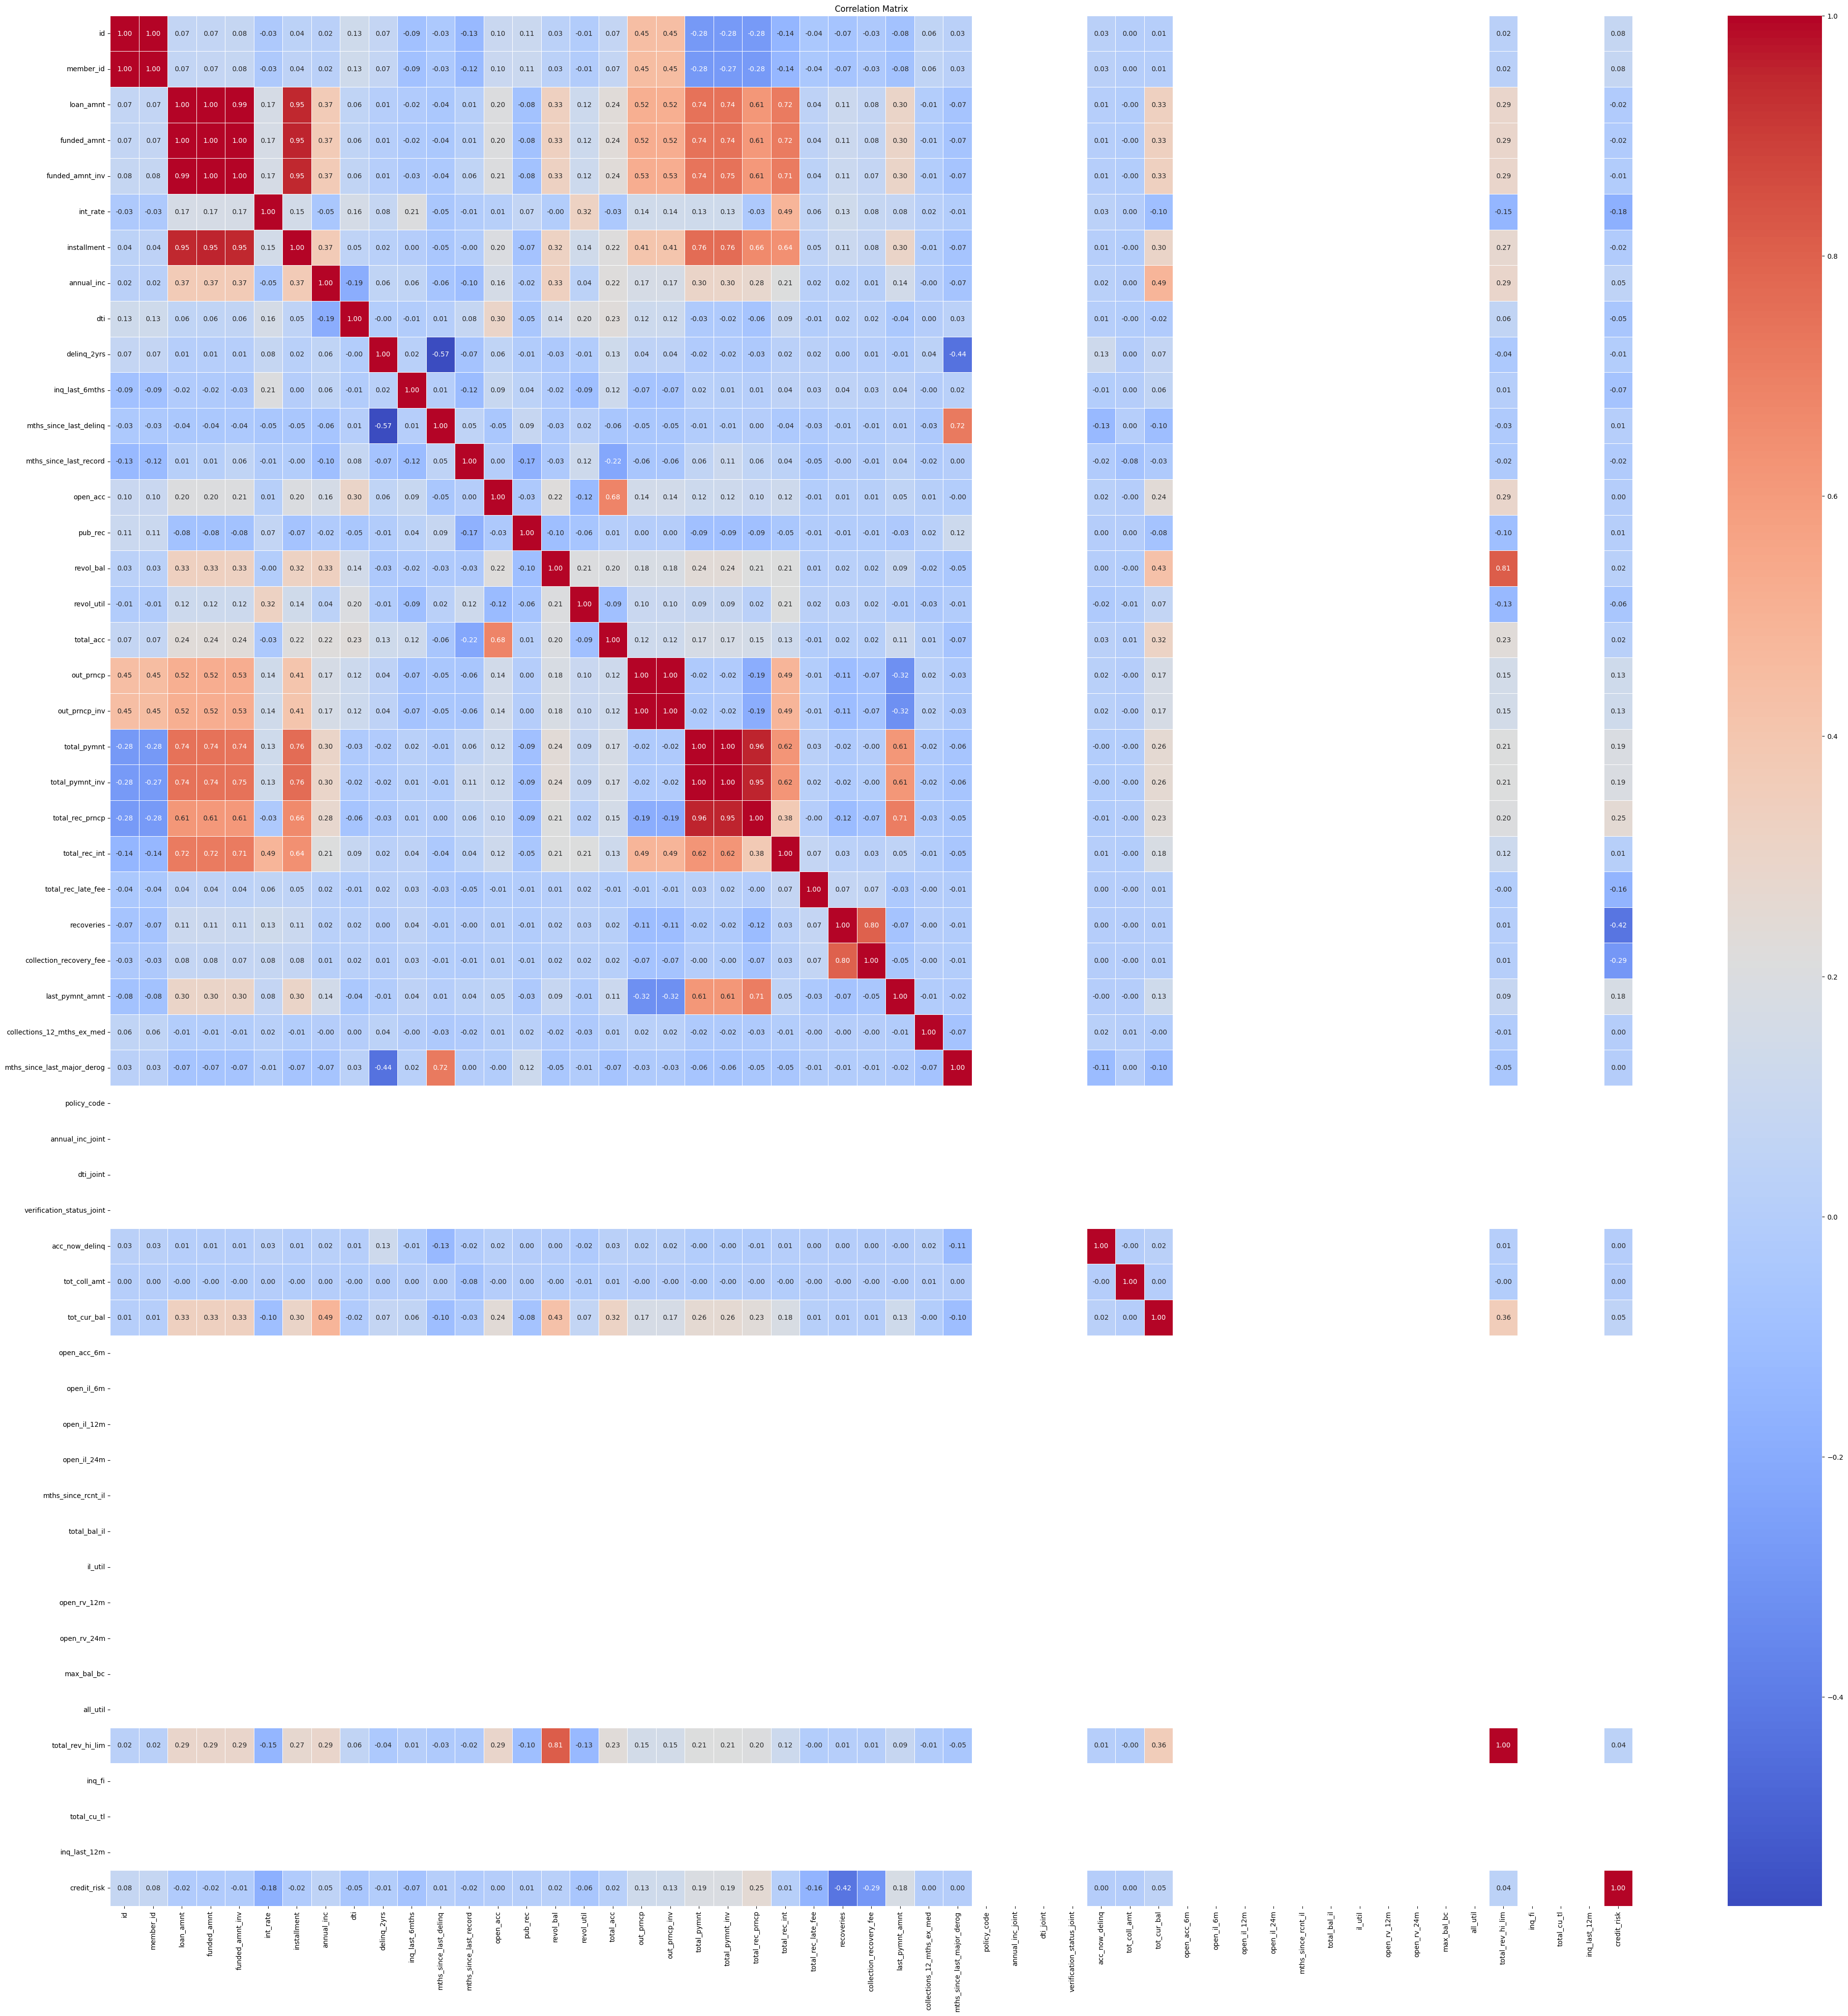

In [345]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(50, 50))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Drop unnecessary feature(s)

In [346]:
# we can see that loan_amnt, funded_amnt, and funded_amnt_inv have very high positive correlations with each other (above 0.99)
# we can combine those columns into one or use one of them

df['combined_amount'] = (df['loan_amnt'] + df['funded_amnt'] + df['funded_amnt_inv']) / 3
# similarly, we can also applied to installment
# since we have already combine 3 columns before
# i will just leave it as it is, then combine it with installment

# total_pymnt, total_pymnt_inv, and total_rec_prncp also have a very high positive correlation (above 0.95)
# we can either use one of them or combine it like we did before

# out_prncp and out_prncp_inv really have a high positive correlation
# keeping both will only cause redundancy

In [347]:
drop_columns = ['id', 'member_id', 'loan_amnt', 'funded_amnt',
                'funded_amnt_inv', 'term', 'grade', 'emp_title', 'emp_length',
                'home_ownership', 'verification_status', 'issue_d',
                'loan_status', 'pymnt_plan', 'url', 'desc', 'title',
                'zip_code', 'addr_state', 'earliest_cr_line',
                'mths_since_last_delinq', 'mths_since_last_record',
                'initial_list_status', 'out_prncp_inv', 'total_pymnt_inv',
                'total_rec_prncp', 'last_pymnt_d', 'next_pymnt_d',
                'last_credit_pull_d', 'collections_12_mths_ex_med',
                'mths_since_last_major_derog', 'policy_code', 'application_type',
                'annual_inc_joint', 'dti_joint', 'verification_status_joint',
                'acc_now_delinq', 'tot_coll_amt', 'open_acc_6m', 'open_il_6m',
                'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
                'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
                'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

# need to evaluate first
worth_consider_columns = ['purpose', 'initial_list_status', 'verification_status'
                          'earliest_cr_line', 'next_pymnt_d', 'last_pymnt_d',
                          'last_credit_pull_d', 'issue_d',
                          'zip_code', 'addr_state', 'tot_cur_bal', 'total_rev_hi_lim']

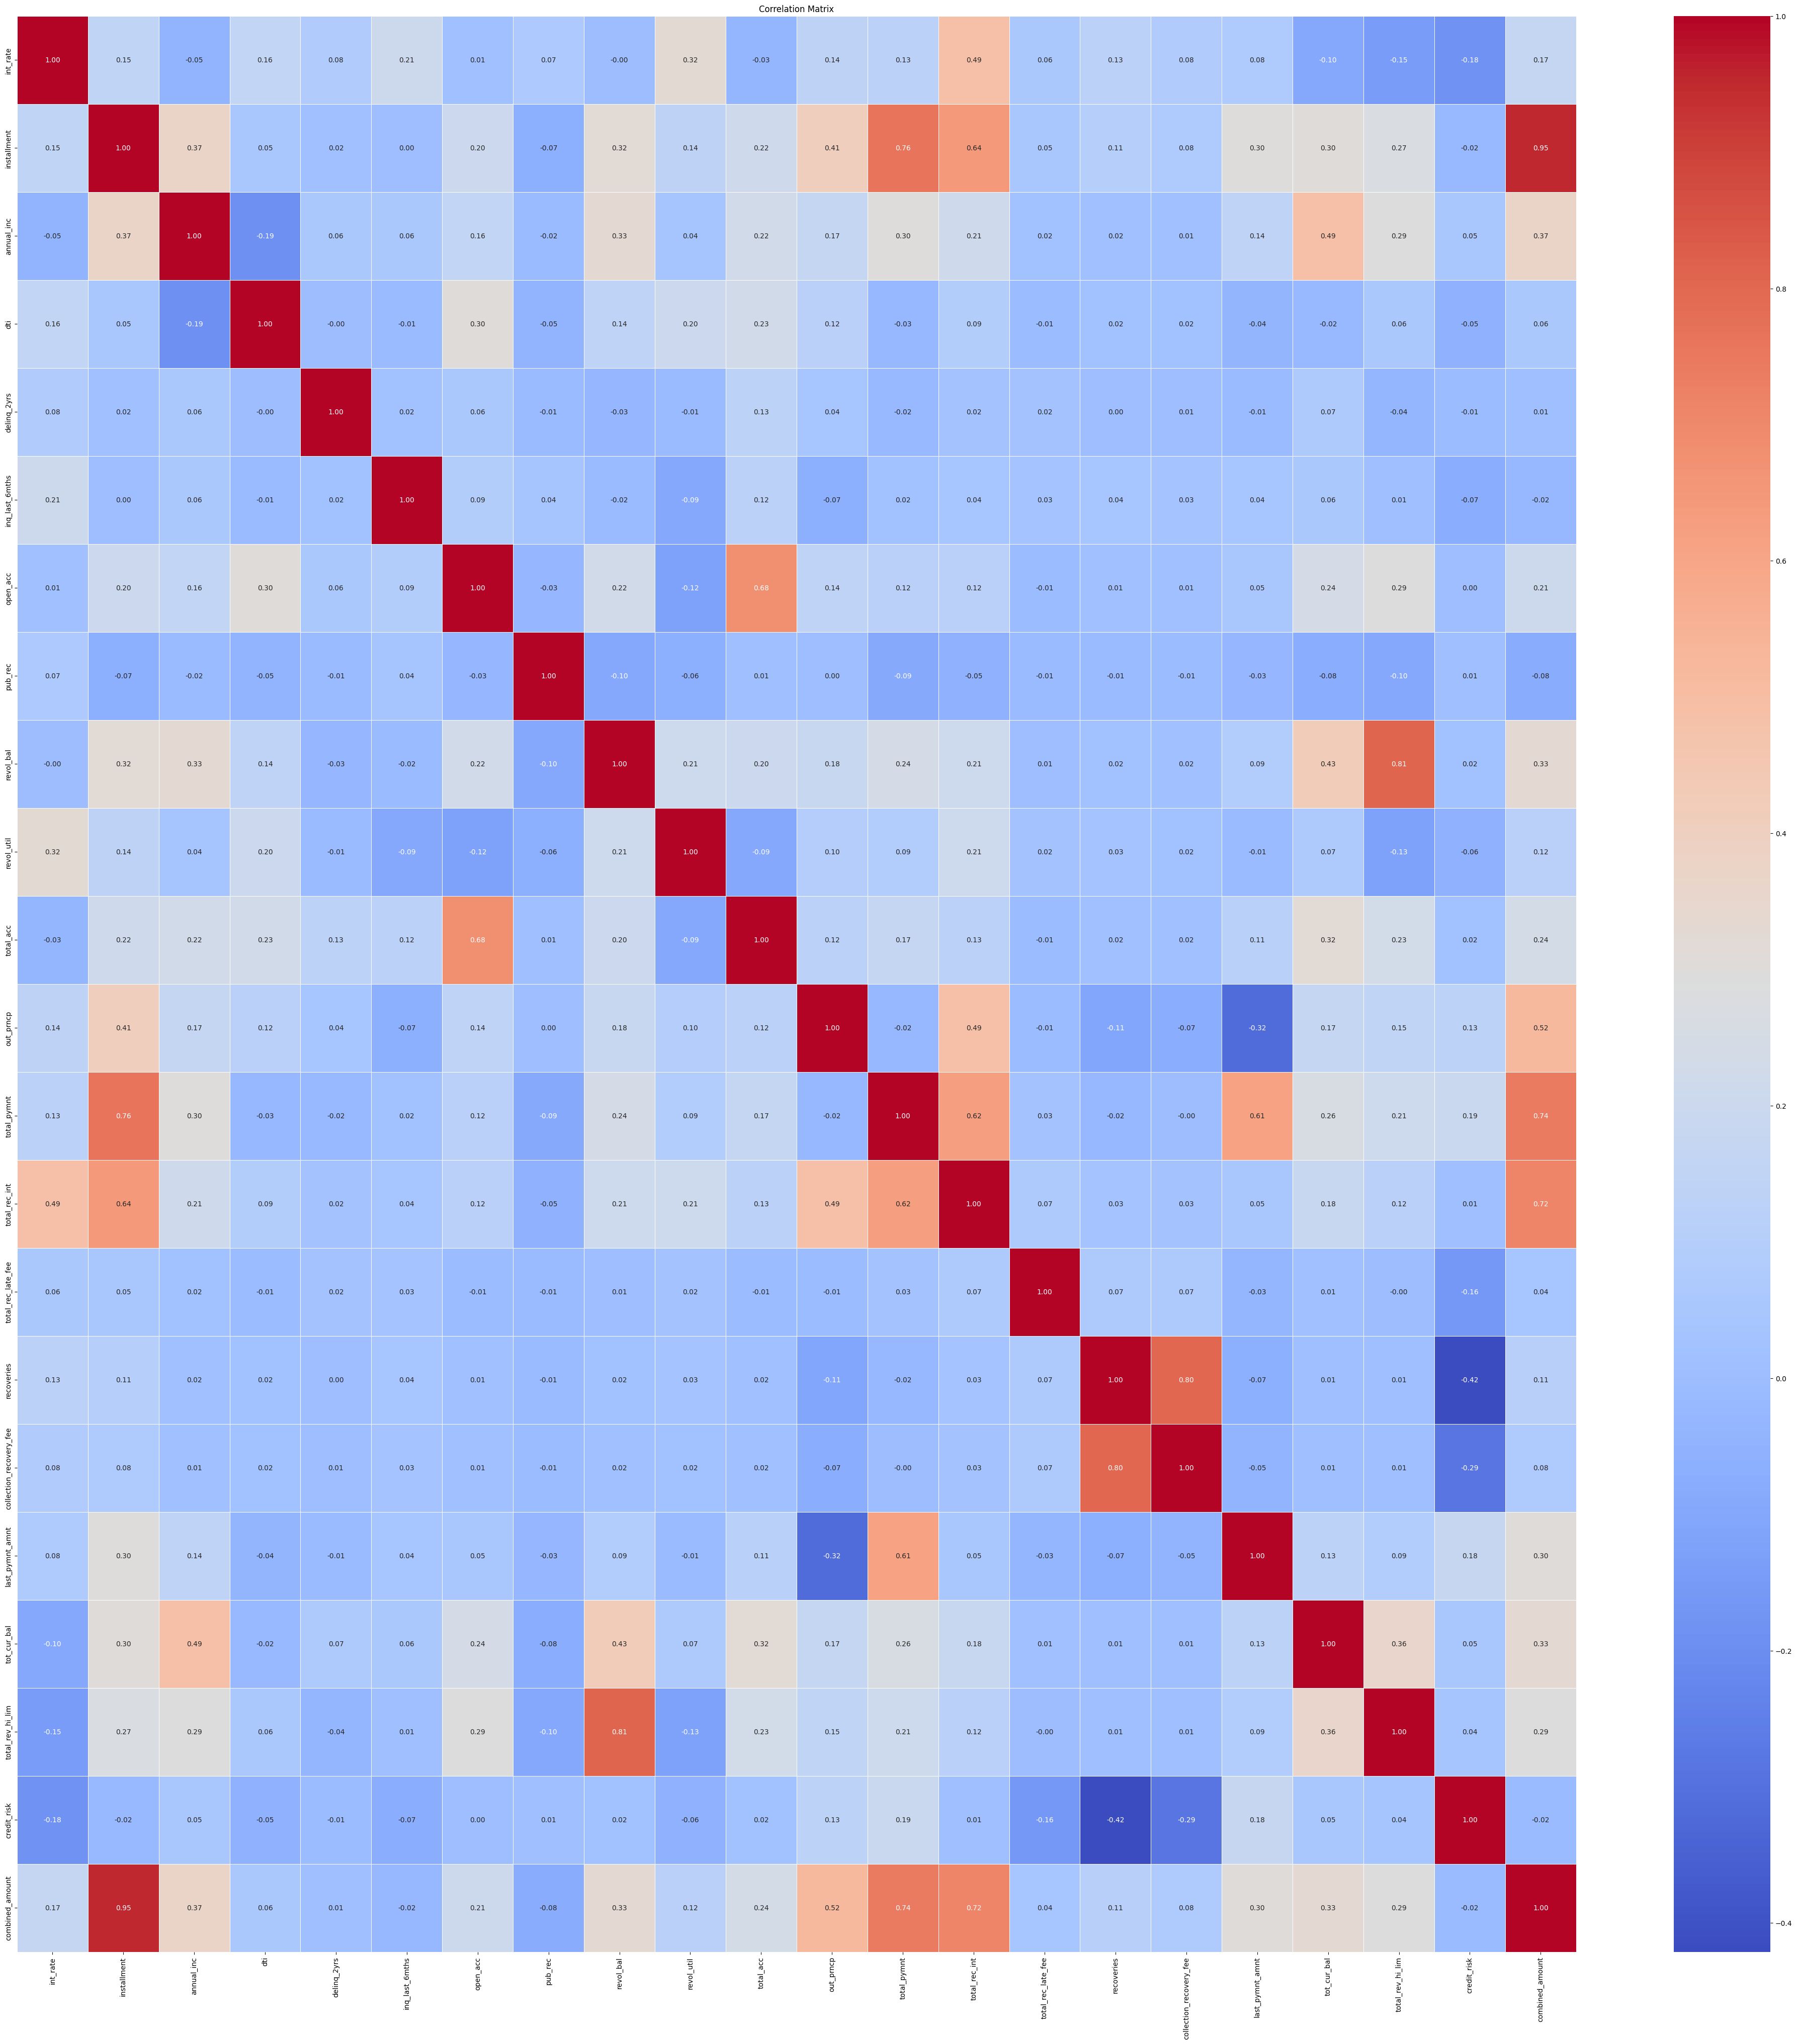

In [348]:
corr = df[[col for col in df.columns if col not in drop_columns]].corr(numeric_only=True)
plt.figure(figsize=(50, 50))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [349]:
df[[col for col in df.columns if col not in drop_columns]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   int_rate                 466285 non-null  float64
 1   installment              466285 non-null  float64
 2   sub_grade                466285 non-null  object 
 3   annual_inc               466281 non-null  float64
 4   purpose                  466285 non-null  object 
 5   dti                      466285 non-null  float64
 6   delinq_2yrs              466256 non-null  float64
 7   inq_last_6mths           466256 non-null  float64
 8   open_acc                 466256 non-null  float64
 9   pub_rec                  466256 non-null  float64
 10  revol_bal                466285 non-null  int64  
 11  revol_util               465945 non-null  float64
 12  total_acc                466256 non-null  float64
 13  out_prncp                466285 non-null  float64
 14  tota

In [350]:
# for checking purposes before consider to dropping it

ft = 'sub_grade'
describe(df[ft])

# temp = pd.DataFrame()
# temp['term'] = df['term'].apply(lambda x: x.split()[0])
# temp['credit_risk'] = df['credit_risk']

check(df[ft], df['credit_risk'], numerical=False)

summary:
NaN	 0     0.00%
count     466285
unique        35
top           B3
freq       31686
Name: sub_grade, dtype: object

number of unique values: 35, which are: ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']

0    B2
1    C4
2    C5
3    C1
4    B5
Name: sub_grade, dtype: object
Cramér's V between sub_grade and 'credit_risk': 0.17769884538661582


## Data cleaning

### Drop defined columns

In [351]:
df.drop(columns=drop_columns, axis=1, inplace=True)

### Encoding

In [352]:
df['sub_grade'] = df['sub_grade'].astype('category').cat.codes

In [353]:
df['purpose'] = df['purpose'].astype('category').cat.codes

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   int_rate                 466285 non-null  float64
 1   installment              466285 non-null  float64
 2   sub_grade                466285 non-null  int8   
 3   annual_inc               466281 non-null  float64
 4   purpose                  466285 non-null  int8   
 5   dti                      466285 non-null  float64
 6   delinq_2yrs              466256 non-null  float64
 7   inq_last_6mths           466256 non-null  float64
 8   open_acc                 466256 non-null  float64
 9   pub_rec                  466256 non-null  float64
 10  revol_bal                466285 non-null  int64  
 11  revol_util               465945 non-null  float64
 12  total_acc                466256 non-null  float64
 13  out_prncp                466285 non-null  float64
 14  tota

### NaN and outlier handling

In [355]:
# try with imputing with median (later: drop)
df['annual_inc'].fillna(df['annual_inc'].median(), inplace=True)

In [356]:
# delete dti outlier
df = df[~outliers(df['dti'], remove=True)]

In [357]:
# option: drop,
# impute with median (preserve the original distribution),
# impute with mean (balance the effect of extreme values)

df = df.dropna(subset=['delinq_2yrs'])

In [358]:
# option: drop,
# impute with median,
# impute with mean

df = df.dropna(subset=['revol_util'])

In [359]:
# delete revol_util outlier
df = df[~outliers(df['revol_util'], remove=True)]

In [360]:
# since tot_cur_bal has a significant amount of missing values
# we will impute it with median

df['tot_cur_bal'].fillna(df['tot_cur_bal'].median(), inplace=True)

In [361]:
# similar to tot_cur_bal

df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].median(), inplace=True)

### Changing data type

In [362]:
df['delinq_2yrs'] = df['delinq_2yrs'].astype(int)

In [363]:
df['inq_last_6mths'] = df['inq_last_6mths'].astype(int)

In [364]:
df['pub_rec'] = df['pub_rec'].astype(int)

In [365]:
df['open_acc'] = df['open_acc'].astype(int)

In [366]:
df['total_acc'] = df['total_acc'].astype(int)

In [367]:
df['total_rev_hi_lim'] = df['total_rev_hi_lim'].astype(int)

In [368]:
is_float(df[df.columns[23]])


0          4991.666667
9          5366.666667
20        19880.720360
26        12908.333333
32         9991.666667
              ...     
466261    14391.666667
466265    31991.666667
466269    13241.666667
466277    17991.666667
466284     9991.666667
Name: combined_amount, Length: 62411, dtype: float64

summary:
outliers 61342 13.17%
NaN	 0     0.00%
count    465883.000000
mean          0.160643
std           0.511006
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          63.000000
Name: pub_rec, dtype: float64



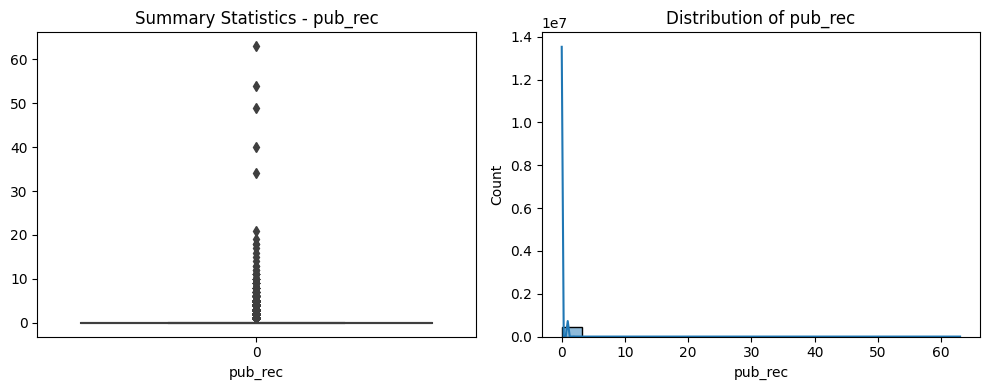

In [369]:
describe(df[df.columns[9]])

### Further feature engineering

In [372]:
# consider to drop installment, and sub_grade
# since it has high correlation with other feature

df.drop(columns=['installment', 'sub_grade'], axis=1, inplace=True)

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465883 entries, 0 to 466284
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   int_rate                 465883 non-null  float64
 1   annual_inc               465883 non-null  float64
 2   purpose                  465883 non-null  int8   
 3   dti                      465883 non-null  float64
 4   delinq_2yrs              465883 non-null  int32  
 5   inq_last_6mths           465883 non-null  int32  
 6   open_acc                 465883 non-null  int32  
 7   pub_rec                  465883 non-null  int32  
 8   revol_bal                465883 non-null  int64  
 9   revol_util               465883 non-null  float64
 10  total_acc                465883 non-null  int32  
 11  out_prncp                465883 non-null  float64
 12  total_pymnt              465883 non-null  float64
 13  total_rec_int            465883 non-null  float64
 14  tota

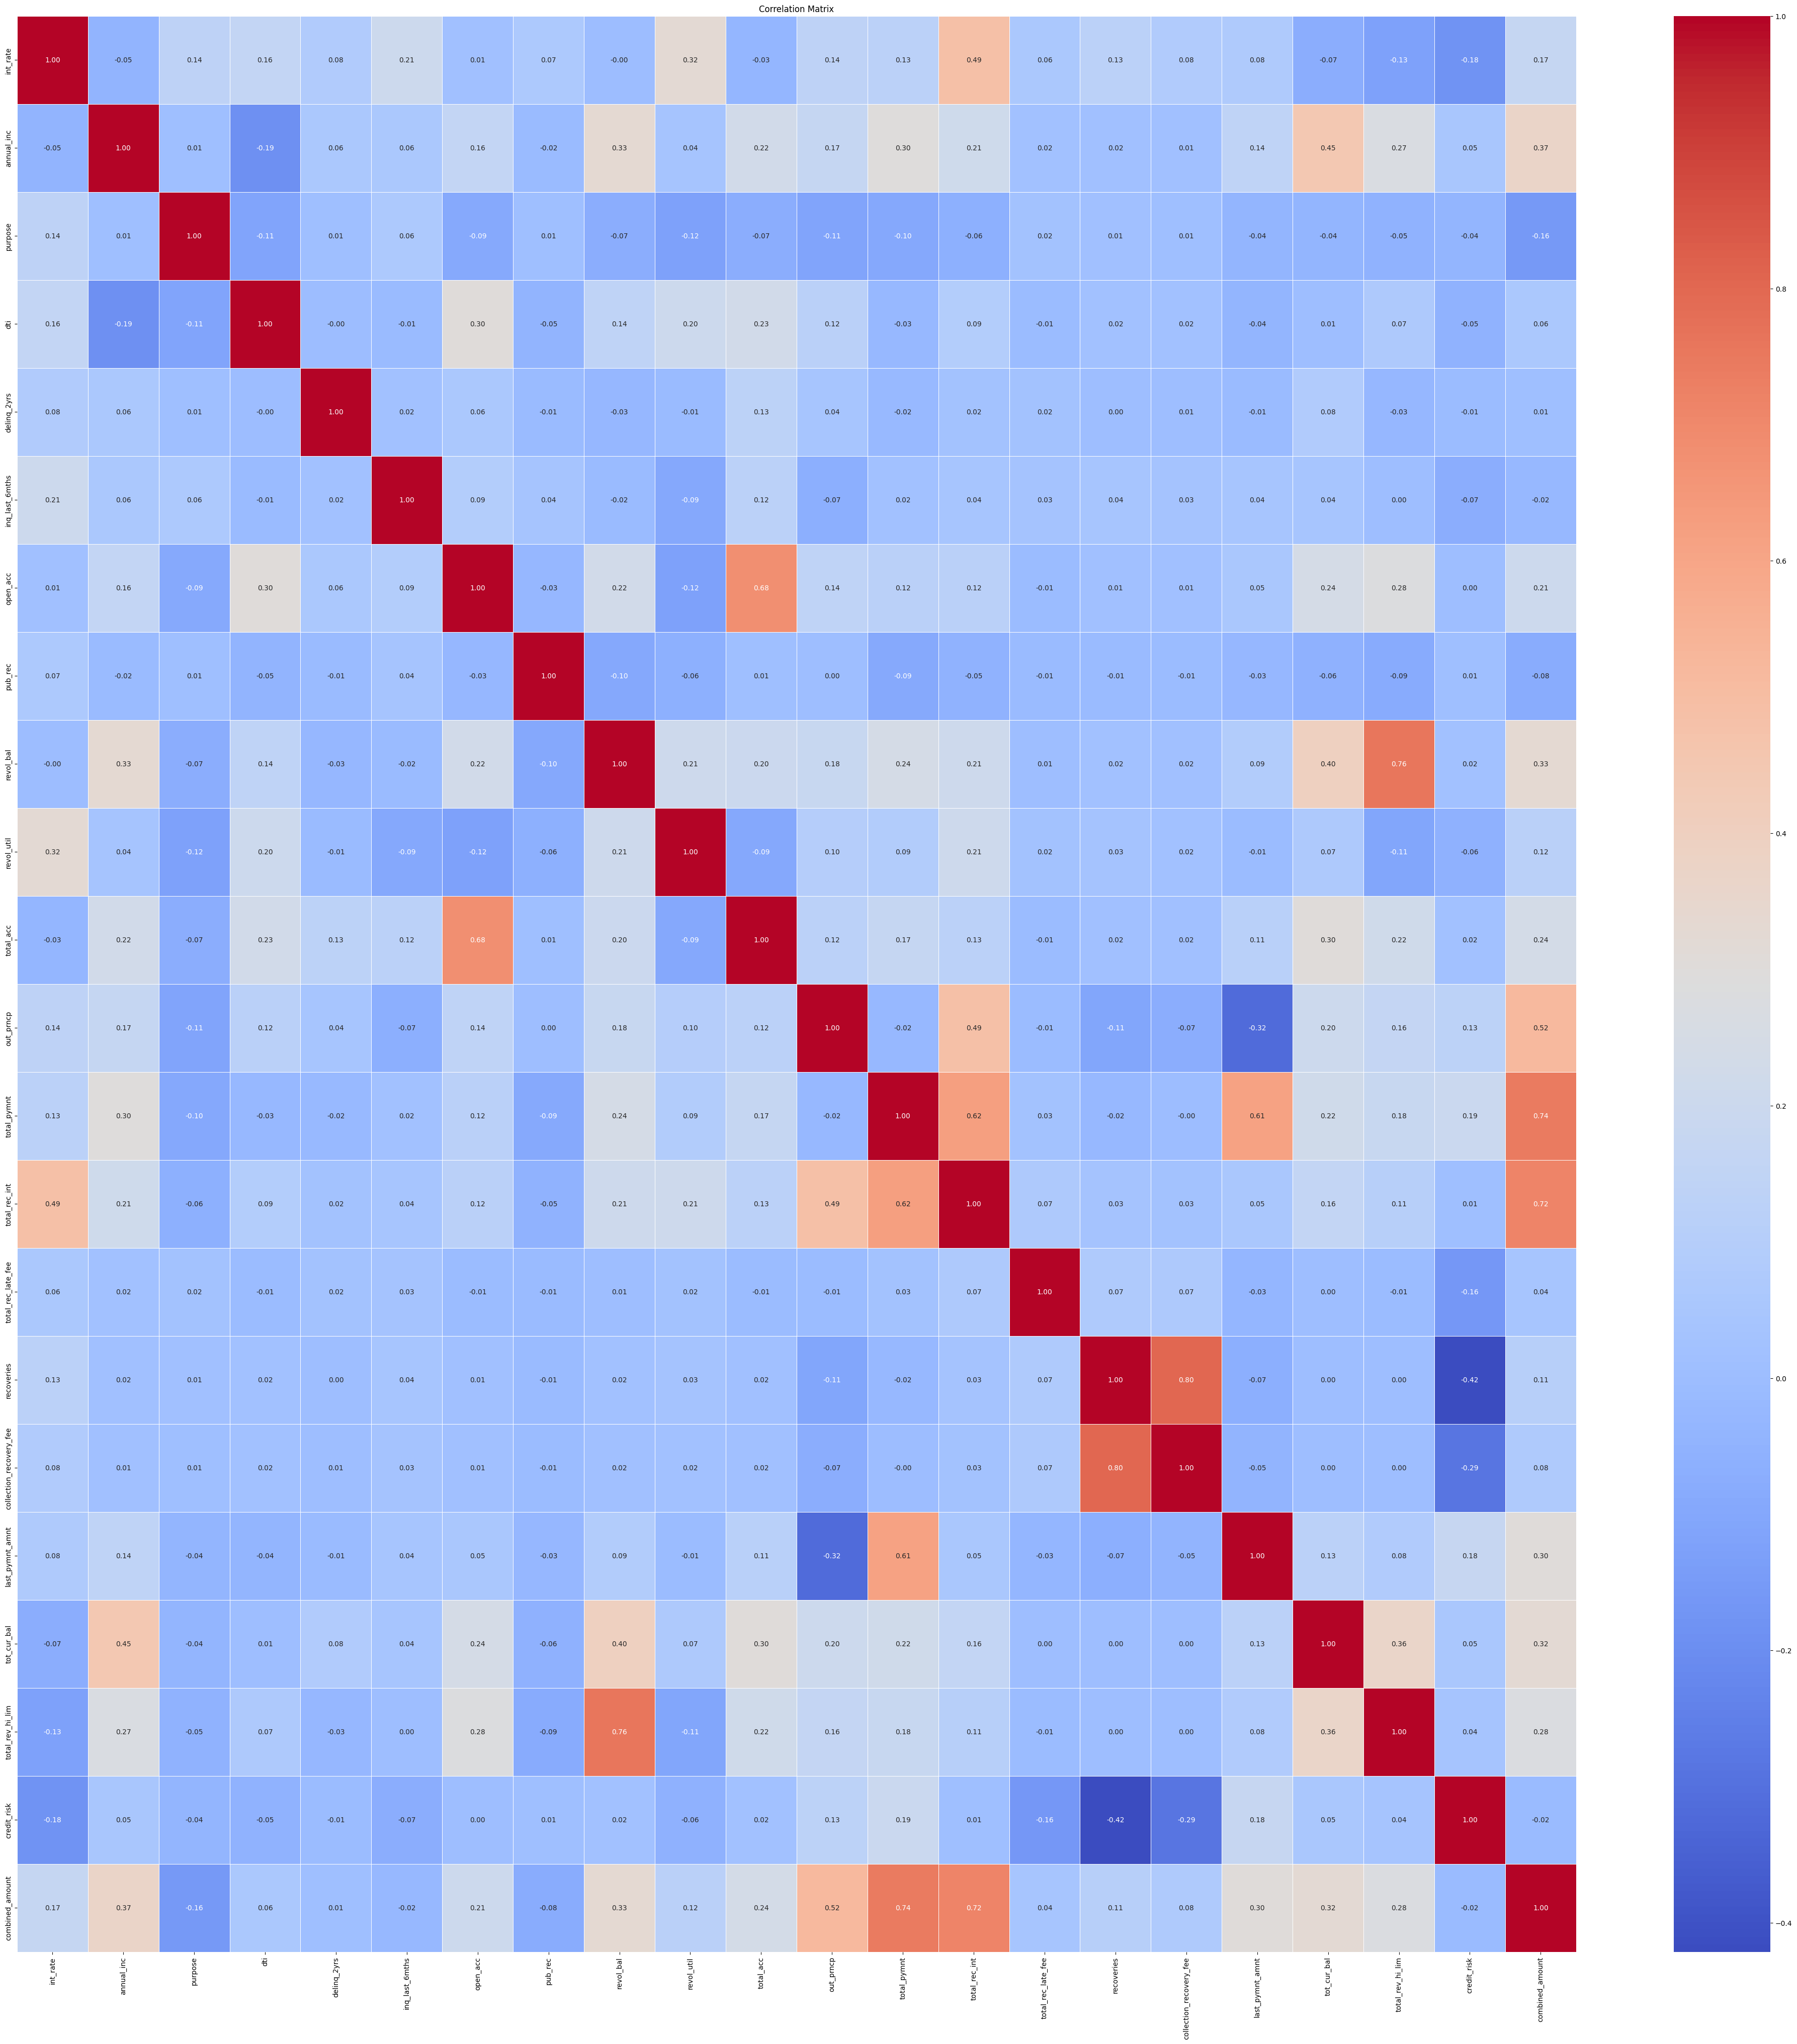

In [391]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(50, 50))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Modelling

In [373]:
model_path = 'model/'
models_training_time = []
models_train_accuracy = []
models_test_accuracy = []
models_mean_acc = []

In [374]:
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

## Data Normalization

In [377]:
skewed_features = ['annual_inc', 'delinq_2yrs',
                  'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
                  'total_acc', 'out_prncp', 'total_pymnt',
                  'total_rec_int', 'total_rec_late_fee', 'recoveries',
                  'collection_recovery_fee', 'last_pymnt_amnt',
                  'tot_cur_bal', 'total_rev_hi_lim', 'combined_amount']  # robust
other_features = ['int_rate', 'dti', 'revol_util']  #standard

robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

In [378]:
X_train[skewed_features] = robust_scaler.fit_transform(X_train[skewed_features])
X_test[skewed_features] = robust_scaler.transform(X_test[skewed_features])

X_train[other_features] = standard_scaler.fit_transform(X_train[other_features])
X_test[other_features] = standard_scaler.transform(X_test[other_features])

In [379]:
X = X.values
y = y.values
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [380]:
# n = 22
# is_float(X[X.columns[n]])
# describe(X[X.columns[n]])

## Logistic regresion model

In [381]:
logreg_model = LogisticRegression(n_jobs=-1)

time_start = datetime.now()

logreg_model.fit(X_train, y_train)

delta = datetime.now() - time_start

print(f'Training time: {delta.seconds//60} minutes {delta.seconds%60} seconds')

print(f'Accuracy on Train Dataset: {logreg_model.score(X_train, y_train)}')
print(f'Accuracy on Test Dataset: {logreg_model.score(X_test, y_test)}')

y_pred = logreg_model.predict(X_test)

cv_scores = eval(X, y, y_test, y_pred, logreg_model)

models_training_time.append(delta.total_seconds())
models_train_accuracy.append(round(logreg_model.score(X_train, y_train), 4))
models_test_accuracy.append(round(logreg_model.score(X_test, y_test), 4))
models_mean_acc.append(round(cv_scores.mean(), 4))

Training time: 0 minutes 7 seconds
Accuracy on Train Dataset: 0.971532521612209
Accuracy on Test Dataset: 0.9710550887021475
Evaluation on the test set:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     11035
           1       0.97      1.00      0.98     82142

    accuracy                           0.97     93177
   macro avg       0.98      0.88      0.92     93177
weighted avg       0.97      0.97      0.97     93177

Cross-validation scores:
[0.97747298 0.97905062 0.98440602 0.94755087 0.96287671]
Mean CV accuracy: 0.9703


## Decision tree model

In [382]:
dectree_model = DecisionTreeClassifier()

time_start = datetime.now()

with parallel_backend('threading'):
  dectree_model.fit(X_train, y_train)

delta = datetime.now() - time_start
print(f'Training time: {delta.seconds//60} minutes {delta.seconds%60} seconds')

print(f'Accuracy on Train Dataset: {dectree_model.score(X_train, y_train)}')
print(f'Accuracy on Test Dataset: {dectree_model.score(X_test, y_test)}')

y_pred = dectree_model.predict(X_test)

cv_scores = eval(X, y, y_test, y_pred, dectree_model)

models_training_time.append(delta.total_seconds())
models_train_accuracy.append(round(dectree_model.score(X_train, y_train), 4))
models_test_accuracy.append(round(dectree_model.score(X_test, y_test), 4))
models_mean_acc.append(round(cv_scores.mean(), 4))

Training time: 0 minutes 13 seconds
Accuracy on Train Dataset: 1.0
Accuracy on Test Dataset: 0.9513077261555963
Evaluation on the test set:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     11035
           1       0.97      0.97      0.97     82142

    accuracy                           0.95     93177
   macro avg       0.88      0.89      0.89     93177
weighted avg       0.95      0.95      0.95     93177

Cross-validation scores:
[0.93841828 0.89551069 0.76226966 0.83143728 0.8851099 ]
Mean CV accuracy: 0.8625


## Random Forest model

In [383]:
rf_model = RandomForestClassifier(n_jobs=-1)

time_start = datetime.now()

rf_model.fit(X_train, y_train)

delta = datetime.now() - time_start
print(f'Training time: {delta.seconds//60} minutes {delta.seconds%60} seconds')

print(f'Accuracy on Train Dataset: {rf_model.score(X_train, y_train)}')
print(f'Accuracy on Test Dataset: {rf_model.score(X_test, y_test)}')

y_pred = rf_model.predict(X_test)

cv_scores = eval(X, y, y_test, y_pred, rf_model)

models_training_time.append(delta.total_seconds())
models_train_accuracy.append(round(rf_model.score(X_train, y_train), 4))
models_test_accuracy.append(round(rf_model.score(X_test, y_test), 4))
models_mean_acc.append(round(cv_scores.mean(), 4))

Training time: 1 minutes 6 seconds
Accuracy on Train Dataset: 0.9999919507601166
Accuracy on Test Dataset: 0.9722785665990534
Evaluation on the test set:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     11035
           1       0.97      1.00      0.98     82142

    accuracy                           0.97     93177
   macro avg       0.98      0.89      0.93     93177
weighted avg       0.97      0.97      0.97     93177

Cross-validation scores:
[0.98286058 0.97551971 0.89255932 0.94820555 0.9632738 ]
Mean CV accuracy: 0.9525


## Gradient Boosting model

In [384]:
gb_model = GradientBoostingClassifier(n_iter_no_change=3, tol=0.001, validation_fraction=0.2)

time_start = datetime.now()

with parallel_backend('threading'):
  gb_model.fit(X_train, y_train)

delta = datetime.now() - time_start

print(f'Training time: {delta.seconds//60} minutes {delta.seconds%60} seconds')

print(f'Accuracy on Train Dataset: {gb_model.score(X_train, y_train)}')
print(f'Accuracy on Test Dataset: {gb_model.score(X_test, y_test)}')

y_pred = gb_model.predict(X_test)

cv_scores = eval(X, y, y_test, y_pred, gb_model)

models_training_time.append(delta.total_seconds())
models_train_accuracy.append(round(gb_model.score(X_train, y_train), 4))
models_test_accuracy.append(round(gb_model.score(X_test, y_test), 4))
models_mean_acc.append(round(cv_scores.mean(), 4))

Training time: 2 minutes 51 seconds
Accuracy on Train Dataset: 0.9680793977022103
Accuracy on Test Dataset: 0.9678890713373473
Evaluation on the test set:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     11035
           1       0.97      1.00      0.98     82142

    accuracy                           0.97     93177
   macro avg       0.98      0.87      0.91     93177
weighted avg       0.97      0.97      0.97     93177

Cross-validation scores:
[0.97773056 0.96659047 0.97076532 0.94811969 0.95936722]
Mean CV accuracy: 0.9645


In [385]:
# save the model
n = len(os.listdir(model_path)) // 5 + 1
joblib.dump(logreg_model, model_path + f'logreg_model_v{n}.pkl')
joblib.dump(dectree_model, model_path + f'dectree_model_v{n}.pkl')
joblib.dump(rf_model, model_path + f'rf_model_v{n}.pkl')
joblib.dump(gb_model, model_path + f'gb_model_v{n}.pkl')

['model/gb_model_v3.pkl']

## Neural Network

In [386]:
loss_scores = []
accuracy_scores = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

callback = EarlyStopping(monitor='loss', patience=3, min_delta=0.001)

model = Sequential([Dense(64, activation='relu', input_shape=(X.shape[1],)),
                    Dense(64, activation='relu'),
                    Dense(1, activation='sigmoid')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

time_start = datetime.now()

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    verbose=0,
                    callbacks=[callback])

delta = datetime.now() - time_start

train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Training time: {delta.seconds//60} minutes {delta.seconds%60} seconds')
print(f'Accuracy on Train Dataset: {train_acc}')
print(f'Accuracy on Test Dataset: {test_acc}')


for train_index, test_index in kfold.split(X, y):
  X_train_cv, X_test_cv = X[train_index], X[test_index]
  y_train_cv, y_test_cv = y[train_index], y[test_index]

  model = Sequential([Dense(64, activation='relu', input_shape=(X.shape[1],)),
                      Dense(64, activation='relu'),
                      Dense(1, activation='sigmoid')])
  
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  model.fit(X_train_cv, y_train_cv,
            epochs=100,
            batch_size=32,
            verbose=0,
            callbacks=[callback])

  loss, accuracy = model.evaluate(X_test_cv, y_test_cv, verbose=0)
  loss_scores.append(loss)
  accuracy_scores.append(accuracy)

mean_loss = np.mean(loss_scores)
mean_accuracy = np.mean(accuracy_scores)

print(f'Cross-validation scores:\n{accuracy_scores}')
print(f'Mean CV accuracy: {mean_accuracy}')

print(f'Cross-validation scores:\n{loss_scores}')
print(f'Mean CV loss: {mean_loss}')

models_training_time.append(delta.total_seconds())
models_train_accuracy.append(round(train_acc, 4))
models_test_accuracy.append(round(test_acc, 4))
models_mean_acc.append(round(mean_accuracy, 4))

2912/2912 [==============================] - 4s 1ms/step - loss: 0.0948 - accuracy: 0.9737
Training time: 2 minutes 39 seconds
Accuracy on Train Dataset: 0.9747253656387329
Accuracy on Test Dataset: 0.9736630320549011
Cross-validation scores:
[0.9624478220939636, 0.9596574306488037, 0.9721497893333435, 0.9721173048019409, 0.9722567796707153]
Mean CV accuracy: 0.9677258253097534
Cross-validation scores:
[0.1561155468225479, 0.18646197021007538, 0.11845359206199646, 0.11650592088699341, 0.12490903586149216]
Mean CV loss: 0.14048921316862106


In [387]:
# save the model
n = len(os.listdir(model_path)) // 5 + 1
model.save(model_path+f'dl_model_v{n}.h5')

In [388]:
models = ['Logistic Regresion', 'Decision Tree', 'Random Forest',
          'Gradient Boosting', 'Neural Network']

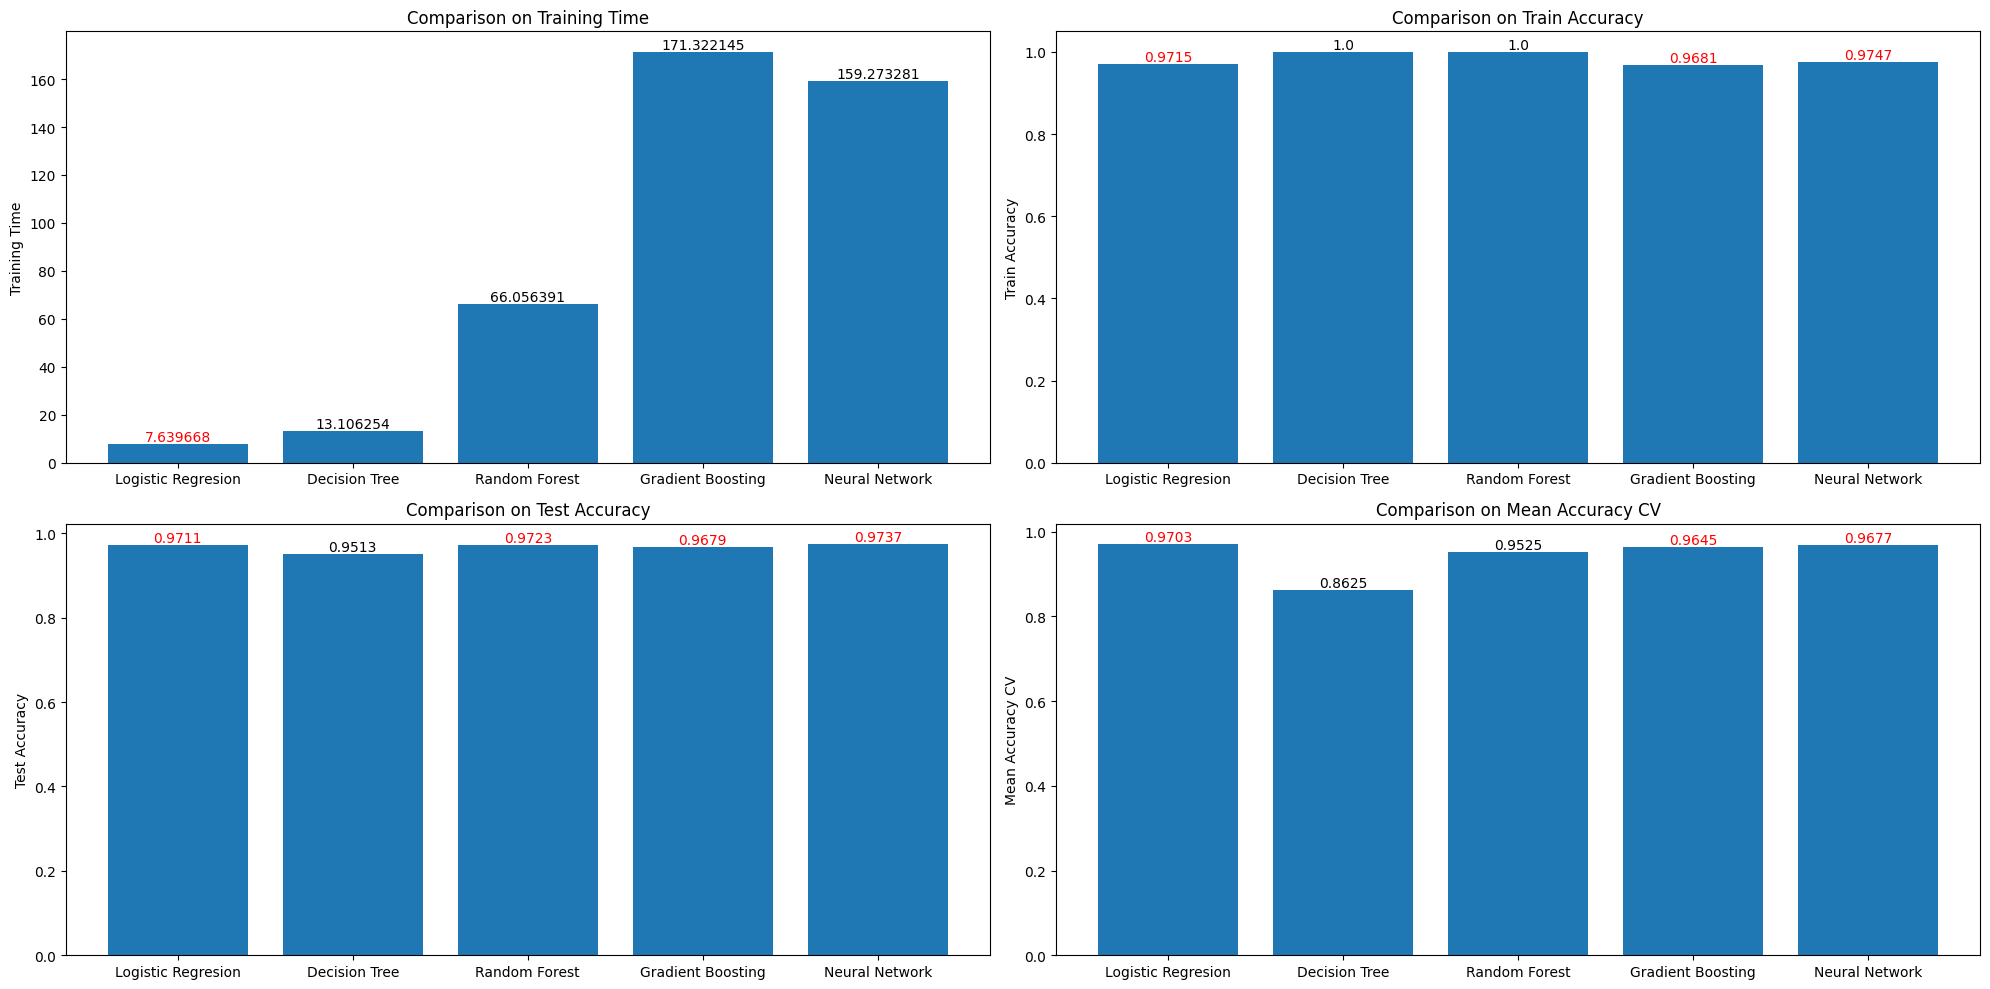

In [392]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.bar(models, models_training_time)
plt.title('Comparison on Training Time')
plt.ylabel('Training Time')
highlighted_models = [0]
for i, v in enumerate(models_training_time):
    if i in highlighted_models:
        plt.text(i, v, str(v), ha='center', va='bottom', color='red')
    else:
        plt.text(i, v, str(v), ha='center', va='bottom')

plt.subplot(2, 2, 2)
plt.bar(models, models_train_accuracy)
plt.title('Comparison on Train Accuracy')
plt.ylabel('Train Accuracy')
highlighted_models = [0, 3, 4]
for i, v in enumerate(models_train_accuracy):
    if i in highlighted_models:
        plt.text(i, v, str(v), ha='center', va='bottom', color='red')
    else:
        plt.text(i, v, str(v), ha='center', va='bottom')

plt.subplot(2, 2, 3)
plt.bar(models, models_test_accuracy)
plt.title('Comparison on Test Accuracy')
plt.ylabel('Test Accuracy')
highlighted_models = [0, 2, 3, 4]
for i, v in enumerate(models_test_accuracy):
    if i in highlighted_models:
        plt.text(i, v, str(v), ha='center', va='bottom', color='red')
    else:
        plt.text(i, v, str(v), ha='center', va='bottom')

plt.subplot(2, 2, 4)
plt.bar(models, models_mean_acc)
plt.title('Comparison on Mean Accuracy CV')
plt.ylabel('Mean Accuracy CV')
highlighted_models = [0, 3, 4]
for i, v in enumerate(models_mean_acc):
    if i in highlighted_models:
        plt.text(i, v, str(v), ha='center', va='bottom', color='red')
    else:
        plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()